# Image Reserve Engine based on VGG16
The dataset is Tiny-ImageNet-200 from [Stanford University](http://cs231n.stanford.edu/tiny-imagenet-200.zip)

## Import Essential Libraries

In [1]:
import tensorflow as tf

import os
import random
import gc

import numpy as np

import h5py

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from model import VGGNet

## Check cuda capability

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6400006267354099447
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10083106816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17757765989617561299
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load Dataset

You have to download the dataset from [Stanford University](http://cs231n.stanford.edu/tiny-imagenet-200.zip) and unzip it to the same directory as this notebook.

If you want to use your own dataset, you can modify the code below.

The datas must a list of images' path like this:
```
['data\\image0.jpg', 'data\\image1.jpg', 'data\\image2.jpg', ...]
```

In [5]:
directories = os.listdir(os.path.join('tiny-imagenet-200', 'train'))
datas = []
for directory in directories:
    datas += [os.path.join('tiny-imagenet-200', 'train', directory, 'images', file) for file in os.listdir(os.path.join('tiny-imagenet-200', 'train', directory, 'images')) if file.endswith('.JPEG')]
print(f'Successfully load {len(datas)} images')

Successfully load 100000 images


In [6]:
datas

['tiny-imagenet-200\\train\\n01443537\\images\\n01443537_0.JPEG',
 'tiny-imagenet-200\\train\\n01443537\\images\\n01443537_1.JPEG',
 'tiny-imagenet-200\\train\\n01443537\\images\\n01443537_10.JPEG',
 'tiny-imagenet-200\\train\\n01443537\\images\\n01443537_100.JPEG',
 'tiny-imagenet-200\\train\\n01443537\\images\\n01443537_101.JPEG',
 'tiny-imagenet-200\\train\\n01443537\\images\\n01443537_102.JPEG',
 'tiny-imagenet-200\\train\\n01443537\\images\\n01443537_103.JPEG',
 ...
 'tiny-imagenet-200\\train\\n01629819\\images\\n01629819_97.JPEG',
 'tiny-imagenet-200\\train\\n01629819\\images\\n01629819_98.JPEG',
 'tiny-imagenet-200\\train\\n01629819\\images\\n01629819_99.JPEG',
 ...]

## Indexing

Indexing in notebook may cause memory leak and efficiency problem. It is recommended to use indexing.py to index the dataset.

In [7]:
def indexing(datas, thread_id, features, image_ids):
    model = VGGNet()
    for i, img_path in enumerate(datas):
        feature_normalized = model.extract_feature(img_path, verbose=0)
        features.append(feature_normalized)
        image_ids.append(img_path.encode())
        print(f'T{thread_id}: Extracted feature from {i+1} images, {len(datas) - i - 1} images left')
        gc.collect() # gc

### Indexing in multi threads

I may try joblib or multiprocessing in the future.

In [8]:
import threading

num_threads = 4 # number of threads to use
datas_split = np.array_split(datas, num_threads) # split datas into num_threads parts

features = []
image_ids = []

threads = []

for i in range(num_threads):
    t = threading.Thread(target=indexing, args=(datas_split[i], i, features, image_ids))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

print('Done')

1/1 [==============================] - 4s 4s/step
T1: Extracted feature from 1 images, 24999 images left
T2: Extracted feature from 1 images, 24999 images left
T0: Extracted feature from 1 images, 24999 images leftT3: Extracted feature from 1 images, 24999 images left

T1: Extracted feature from 2 images, 24998 images left
T2: Extracted feature from 2 images, 24998 images left
T0: Extracted feature from 2 images, 24998 images left
T3: Extracted feature from 2 images, 24998 images left
T1: Extracted feature from 3 images, 24997 images left
T2: Extracted feature from 3 images, 24997 images left
T0: Extracted feature from 3 images, 24997 images left
T3: Extracted feature from 3 images, 24997 images left
T1: Extracted feature from 4 images, 24996 images left
T0: Extracted feature from 4 images, 24996 images left
T3: Extracted feature from 4 images, 24996 images left
T2: Extracted feature from 4 images, 24996 images left
T1: Extracted feature from 5 images, 24995 images left
...
T3: Extract

### Output Indexing Result to hdf5(.h5) file

In [9]:
features = np.array(features)
image_ids = np.array(image_ids)

output = h5py.File('features.h5', 'w')
output.create_dataset('features', data=features)
output.create_dataset('image_ids', data=image_ids)
output.close()

In [10]:
features.shape

(100000, 512)

### Garbage Collection

In [11]:
# GC
del features
del image_ids
del datas
del datas_split
del directories
del directory

## Test Query

### Load Dataset

In [12]:
datasets = h5py.File('features.h5', 'r')
features = datasets['features'][:]
image_ids = datasets['image_ids'][:]
datasets.close()

### Get an Image from indexed data

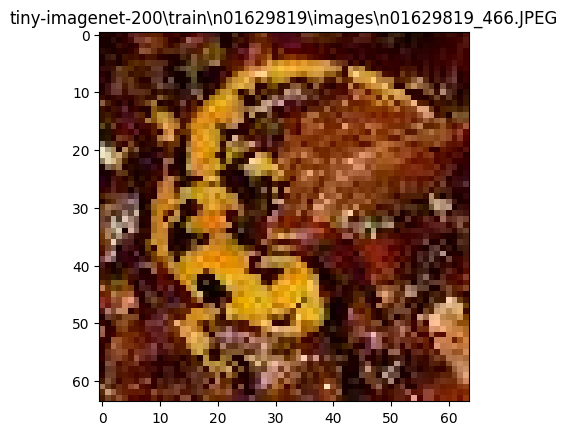

In [13]:
query_img_path = image_ids.astype(str)[random.randint(0, len(image_ids))]
query_img = mpimg.imread(query_img_path)
plt.title(query_img_path)
plt.imshow(query_img)
plt.show()

### Load Model

In [14]:
model = VGGNet()

1/1 [==============================] - 0s 175ms/step


### Get Feature Vector and Query Result

In [15]:
query_feature = model.extract_feature(query_img_path)
scores = np.dot(query_feature, features.T)
rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]

1/1 [==============================] - 0s 50ms/step


In [16]:
scores

array([0.6103591 , 0.5955294 , 0.5033884 , ..., 0.50381625, 0.65443796,
       0.5415088 ], dtype=float32)

In [17]:
rank_ID

array([ 3631, 10236, 65887, ..., 96983, 80211, 64757], dtype=int64)

In [18]:
rank_score

array([0.9999999 , 0.8283447 , 0.8249883 , ..., 0.22753394, 0.22640432,
       0.17471811], dtype=float32)

In [19]:
imlist = [image_ids.astype(str)[index] for i, index in enumerate(rank_ID[0:10])]
print("top %d images in order are:" % 10, '\n' + '\n'.join(imlist))

top 10 images in order are: 
tiny-imagenet-200\train\n01629819\images\n01629819_466.JPEG
tiny-imagenet-200\train\n01742172\images\n01742172_152.JPEG
tiny-imagenet-200\train\n02927161\images\n02927161_74.JPEG
tiny-imagenet-200\train\n03089624\images\n03089624_475.JPEG
tiny-imagenet-200\train\n02927161\images\n02927161_348.JPEG
tiny-imagenet-200\train\n01784675\images\n01784675_408.JPEG
tiny-imagenet-200\train\n02927161\images\n02927161_166.JPEG
tiny-imagenet-200\train\n07695742\images\n07695742_432.JPEG
tiny-imagenet-200\train\n01944390\images\n01944390_130.JPEG
tiny-imagenet-200\train\n01742172\images\n01742172_213.JPEG


### Show Top 10 Results

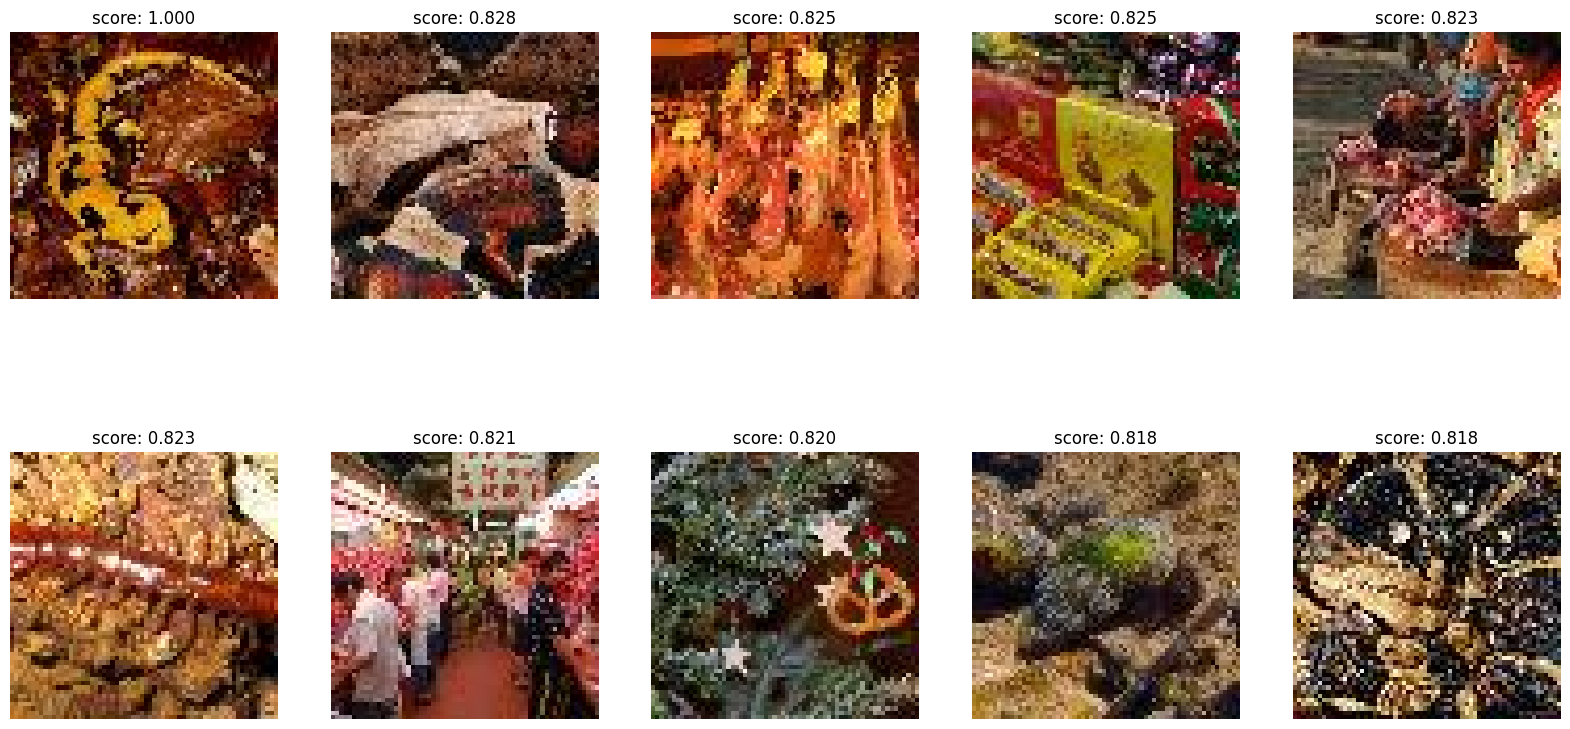

In [20]:
# draw top 10 images
plt.figure(figsize=(20, 10))
for i, im in enumerate(imlist):
    image = mpimg.imread(im)
    plt.subplot(2, 5, i+1)
    plt.title(f'score: {rank_score[i]:.3f}')
    plt.imshow(image)
    plt.axis('off')